In [4]:
import numpy as np
from scipy.signal import find_peaks, peak_prominences, peak_widths
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import pandas as pd


In [1]:
# First we will download all the .lc files and create a text file containing the paths.

In [5]:
import os

# Directory containing the .lc files
lc_directory = '/content/'  # Replace with the actual directory path
# Get a list of all .lc files in the directory
lc_files = [f for f in os.listdir(lc_directory) if f.endswith('.lc')]
with open('lc_file_paths.txt', 'w') as file:
    for lc_file in lc_files:
        file.write(os.path.join(lc_directory, lc_file) + '\n')

print("File paths written to lc_file_paths.txt")


File paths written to lc_file_paths.txt


In [6]:
#extracting useful features
def evaluate(filename):
    hdulist = fits.open(filename)
    times, rates = hdulist[1].data["TIME"], hdulist[1].data["RATE"]
    hdulist.close()

    found = []
    g = gaussian_filter(rates, sigma=10)
    peaks, _ = find_peaks(g)

    prominences, _, _ = peak_prominences(g, peaks)
    if len(prominences) == 0:
        return []

    selected = prominences > 0.5 * (np.min(prominences) + np.max(prominences))
    if len(selected) == 0:
        return []

    top = peaks[selected]
    if len(top) > 10:
        return []
    eigth_peak_widths = peak_widths(g, top, rel_height=0.8)

    per = np.percentile(g, 75)

    for i in range(len(g[top])):
        found.append({
            'start_time': times[int(eigth_peak_widths[2][i])],
            'end_time': times[int(eigth_peak_widths[3][i])],
            'max_time': times[top[i]],
            'peak_width': eigth_peak_widths[0][i],
            'peak_risetime': top[i] - eigth_peak_widths[2][i],
            'peak_falltime': eigth_peak_widths[3][i] - top[i],
            'peak_flux': rates[top[i]],
        })

    return found


In [7]:

def process(file_paths_file):
    with open(file_paths_file, 'r') as file:
        file_paths = file.read().splitlines()

    # Initialize an empty list to store data frames
    dataframes = []

    for file_path in file_paths:
        found = evaluate(file_path)
        # Convert found list of dicts to a DataFrame and add to list
        if found:  # If found is not empty
            df_temp = pd.DataFrame(found)
            dataframes.append(df_temp)

    # Concatenate all dataframes in the list into a single DataFrame
    if dataframes:  # If there is any data to concatenate
        df = pd.concat(dataframes, ignore_index=True)
        df.to_csv('data.csv', index=False)
    else:
        print("No data to save to CSV.")

file_paths_file = 'lc_file_paths.txt'

process(file_paths_file)


In [8]:
df_data=pd.read_csv('data.csv')

In [9]:
df_data.head()

,start_time,end_time,max_time,peak_width,peak_risetime,peak_falltime,peak_flux
0,2.423615e+08,2.423649e+08,2.423621e+08,1871.728147,692.229916,1179.498231,11271.995
1,2.423673e+08,2.423685e+08,2.423677e+08,1203.455411,367.385066,836.070345,10143.102
2,2.423731e+08,2.423788e+08,2.423734e+08,3446.115371,304.311398,3141.803973,13480.430
3,2.423806e+08,2.423813e+08,2.423808e+08,711.825812,159.669295,552.156517,12899.373
4,2.424025e+08,2.424029e+08,2.424026e+08,426.693629,103.797562,322.896067,11291.787


In [10]:
df_data.shape


(7, 7)

In [11]:
import astropy
import scipy
from astropy.io import fits
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks, peak_prominences

In [12]:
#Applying Peak detection process by setting a threshold,also applying kmeans algo to categorise different type of bursts
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

class x_ray_burst:
    def __init__(self, gti_filename, lc_filename):
        self.gti_filename = gti_filename
        self.lc_filename = lc_filename

    def data(self):
        # Load GTI and LC data
        gti_hdulist = fits.open(self.gti_filename)
        gti_data = gti_hdulist[1].data
        gti_start_times = gti_data['START']
        gti_end_times = gti_data['STOP']
        gti_hdulist.close()

        lc_hdulist = fits.open(self.lc_filename)
        lc_data = lc_hdulist[1].data
        lc_times = lc_data['TIME']
        lc_rates = lc_data['RATE']
        lc_hdulist.close()

        return gti_start_times, gti_end_times, lc_times, lc_rates

    def combined_data(self):
        gti_start_times, gti_end_times, lc_times, lc_rates = self.data()
        filtered_lc_times = []
        filtered_lc_values = []

        # Filter the LC data based on valid GTI times
        for i in range(len(lc_times)):
            for j in range(len(gti_start_times)):
                if gti_start_times[j] <= lc_times[i] <= gti_end_times[j]:
                    filtered_lc_times.append(lc_times[i])
                    filtered_lc_values.append(lc_rates[i])
                    break

        return filtered_lc_times, filtered_lc_values

    def plot_combined_data(self):
        times, values = self.combined_data()
        plt.plot(times, values)
        plt.xlabel("Time")
        plt.ylabel("XRay Flux")
        plt.show()

    def peaks(self):
        times, values = self.combined_data()
        smoothed_values = gaussian_filter1d(values, sigma=5)

        # Plot the smoothed data
        plt.figure(figsize=(12, 6))
        plt.plot(times, smoothed_values, label='Smoothed Data (Gaussian)')
        plt.xlabel("Time")
        plt.ylabel("XRay Flux")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Detect peaks
        peaks, _ = find_peaks(smoothed_values, height=10, prominence=1000)
        prominences = peak_prominences(smoothed_values, peaks)[0]

        # Plot detected peaks
        plt.figure(figsize=(10, 6))
        plt.plot(smoothed_values, label='Smoothed Data')
        plt.plot(peaks, smoothed_values[peaks], 'ro', label='Detected Peaks')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

        return times, smoothed_values, peaks

    def extract_features(self):
        times, smoothed_values, peaks = self.peaks()
        features = []

        for i in range(len(peaks)):
            peak_idx = peaks[i]
            start_idx = np.where(smoothed_values[:peak_idx] <= 1)[0]
            end_idx = np.where(smoothed_values[peak_idx:] <= 1)[0]

            if len(start_idx) > 0:
                burst_start = times[start_idx[-1]]
            else:
                burst_start = times[0]

            if len(end_idx) > 0:
                burst_end = times[peak_idx + end_idx[0]]
            else:
                burst_end = times[-1]

            burst_duration = burst_end - burst_start
            peak_flux = smoothed_values[peak_idx]
            rise_time = times[peak_idx] - burst_start
            decay_time = burst_end - times[peak_idx]

            features.append({
                'burst_start': burst_start,
                'burst_end': burst_end,
                'peak_time': times[peak_idx],
                'burst_duration': burst_duration,
                'peak_flux': peak_flux,
                'rise_time': rise_time,
                'decay_time': decay_time
            })

        return pd.DataFrame(features)

    def cluster_bursts(self, n_clusters=5):
        # Extract features for K-means clustering
        df_features = self.extract_features()

        # Select features for clustering
        X = df_features[['burst_duration', 'peak_flux', 'rise_time', 'decay_time']].values

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Apply K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        df_features['cluster'] = kmeans.fit_predict(X_scaled)

        # Map cluster labels to meaningful burst types
        cluster_labels = {
            0: 'Normal Burst',
            1: 'Miniburst',
            2: 'Mesoburst',
            3: 'Structured Burst',
            4: 'Microburst'
        }

        df_features['burst_type'] = df_features['cluster'].map(cluster_labels)

        # Print the results
        print(df_features[['burst_start', 'burst_end', 'peak_time', 'burst_duration', 'peak_flux', 'rise_time', 'decay_time', 'burst_type']])

        return df_features

    def visualize_clusters(self, df_features):
        # Scatter plot to visualize clusters (using two features for simplicity)
        plt.figure(figsize=(10, 6))
        plt.scatter(df_features['peak_flux'], df_features['burst_duration'], c=df_features['cluster'], cmap='viridis', s=100)
        plt.xlabel("Peak Flux")
        plt.ylabel("Burst Duration")
        plt.title("K-Means Clustering of X-ray Bursts")
        plt.colorbar(label='Cluster')
        plt.grid(True)
        plt.show()



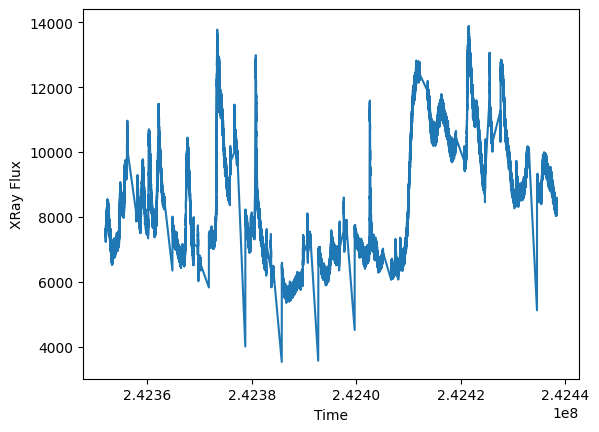

In [21]:
# Assign the file paths directly instead of using input()
y = "/content/ch2_xsm_20240906_v1_level2.lc"
x = "/content/ch2_xsm_20240906_v1_level2.gti"
gti_filename = x
lc_filename = y

# Instantiate the x_ray_burst class and call its methods
burst_detection = x_ray_burst(gti_filename, lc_filename)

# Plot the combined data
burst_detection.plot_combined_data()


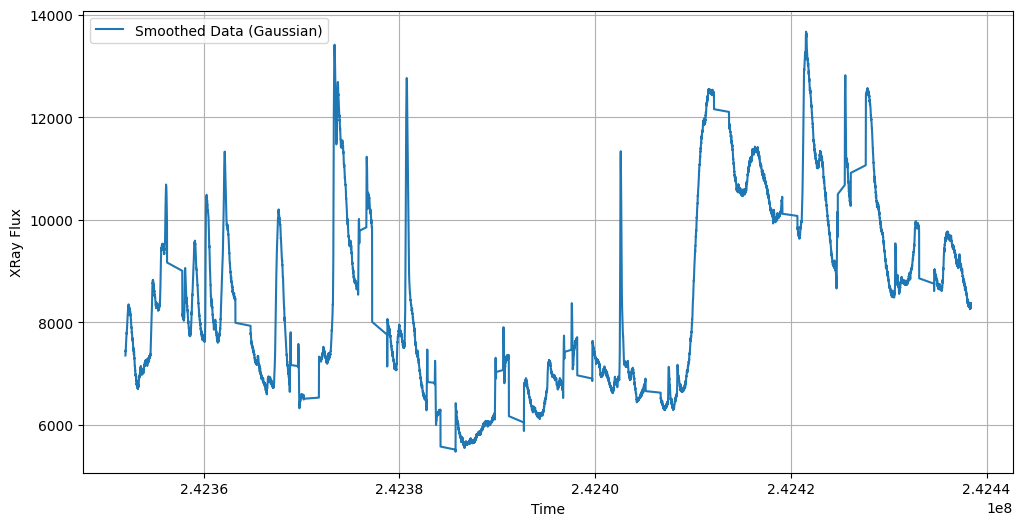

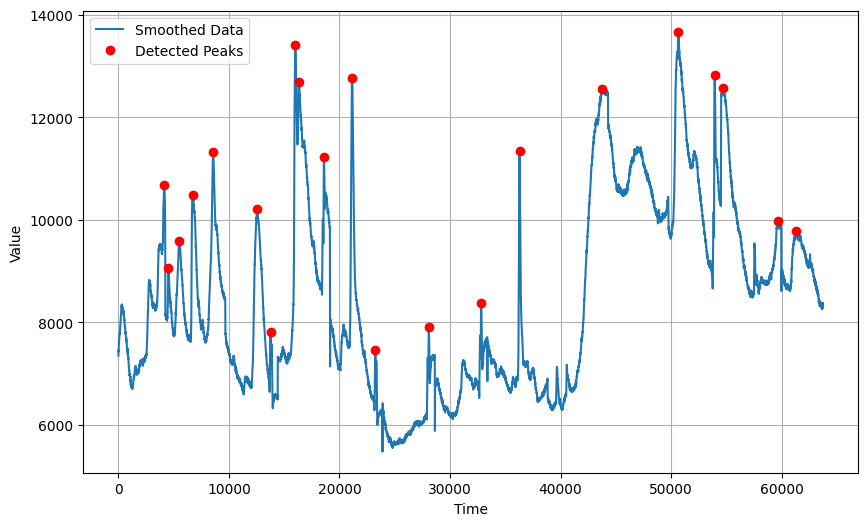

([242352000.33633,
  242352001.33633,
  242352002.33633,
  242352003.33633,
  242352004.33633,
  242352005.33633,
  242352006.33633,
  242352007.33633,
  242352008.33633,
  242352009.33633,
  242352010.33633,
  242352011.33633,
  242352012.33633,
  242352013.33633,
  242352014.33633,
  242352015.33633,
  242352016.33633,
  242352017.33633,
  242352018.33633,
  242352019.33633,
  242352020.33633,
  242352021.33633,
  242352022.33633,
  242352023.33633,
  242352024.33633,
  242352025.33633,
  242352026.33633,
  242352027.33633,
  242352028.33633,
  242352029.33633,
  242352030.33633,
  242352031.33633,
  242352032.33633,
  242352033.33633,
  242352034.33633,
  242352035.33633,
  242352036.33633,
  242352037.33633,
  242352038.33633,
  242352039.33633,
  242352040.33633,
  242352041.33633,
  242352042.33633,
  242352043.33633,
  242352044.33633,
  242352045.33633,
  242352046.33633,
  242352047.33633,
  242352048.33633,
  242352049.33633,
  242352050.33633,
  242352051.33633,
  242352052.

In [22]:
# Detect and visualize peaks
burst_detection.peaks()


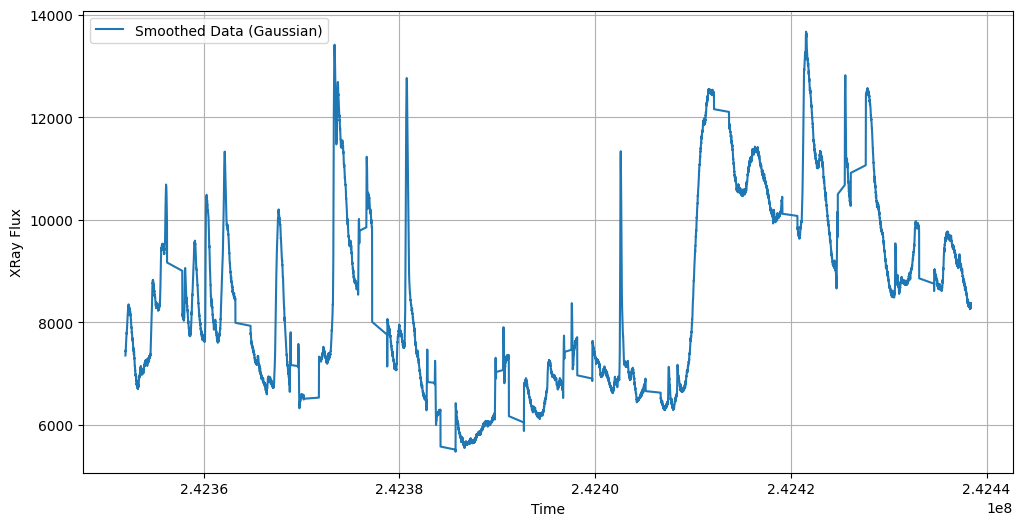

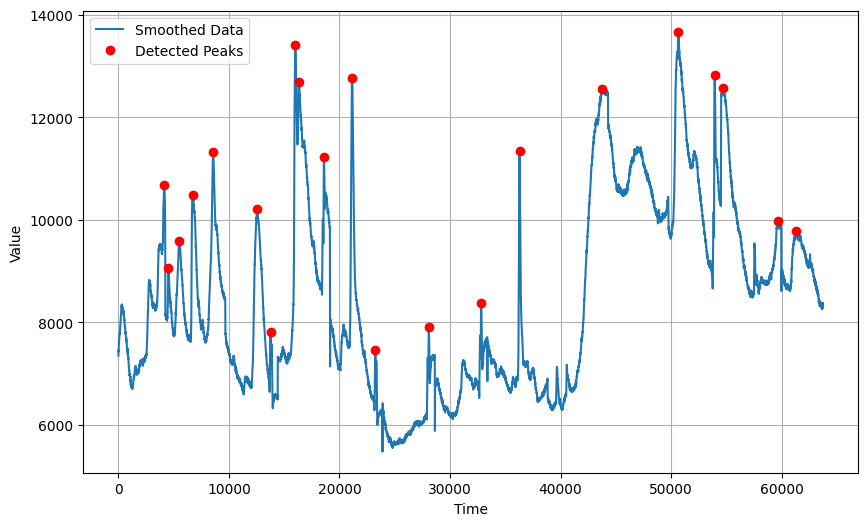

,burst_start,burst_end,peak_time,burst_duration,peak_flux,rise_time,decay_time
0,2.423520e+08,2.424384e+08,2.423562e+08,86398.0,10685.740234,4152.0,82246.0
1,2.423520e+08,2.424384e+08,2.423581e+08,86398.0,9051.581055,6089.0,80309.0
2,2.423520e+08,2.424384e+08,2.423591e+08,86398.0,9591.970703,7095.0,79303.0
3,2.423520e+08,2.424384e+08,2.423603e+08,86398.0,10486.041992,8289.0,78109.0
4,2.423520e+08,2.424384e+08,2.423621e+08,86398.0,11328.181641,10146.0,76252.0
5,2.423520e+08,2.424384e+08,2.423677e+08,86398.0,10201.063477,15656.0,70742.0
6,2.423520e+08,2.424384e+08,2.423689e+08,86398.0,7806.319336,16884.0,69514.0
7,2.423520e+08,2.424384e+08,2.423734e+08,86398.0,13412.038086,21374.0,65024.0
8,2.423520e+08,2.424384e+08,2.423737e+08,86398.0,12686.586914,21709.0,64689.0
9,2.423520e+08,2.424384e+08,2.423767e+08,86398.0,11226.740234,24659.0,61739.0


In [24]:
# Get combined data and calculate features
times, smoothed_values = burst_detection.combined_data()
burst_detection.extract_features() # Call the correct method name: extract_features()

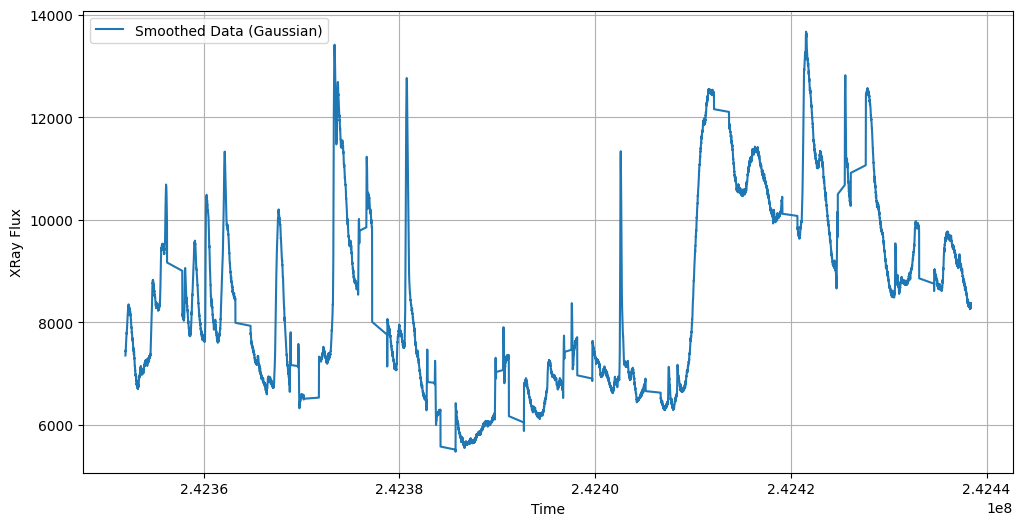

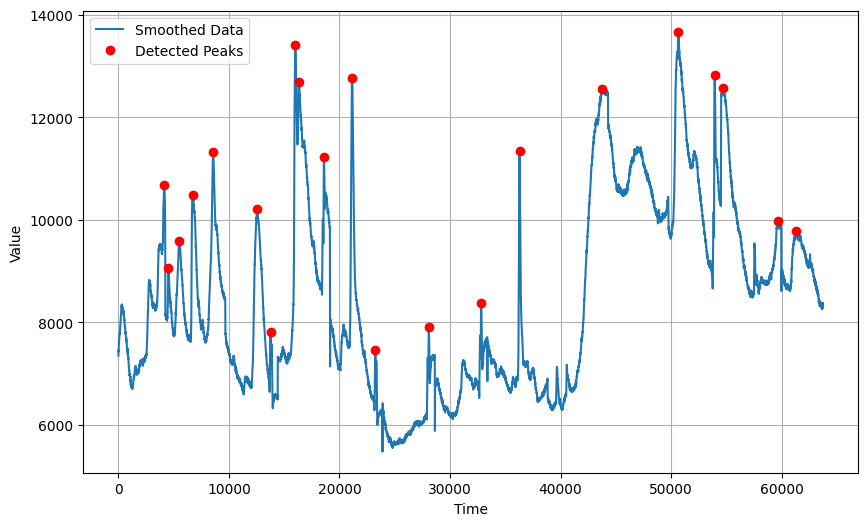

     burst_start     burst_end     peak_time  burst_duration     peak_flux  \
0   2.423520e+08  2.424384e+08  2.423562e+08         86398.0  10685.740234   
1   2.423520e+08  2.424384e+08  2.423581e+08         86398.0   9051.581055   
2   2.423520e+08  2.424384e+08  2.423591e+08         86398.0   9591.970703   
3   2.423520e+08  2.424384e+08  2.423603e+08         86398.0  10486.041992   
4   2.423520e+08  2.424384e+08  2.423621e+08         86398.0  11328.181641   
5   2.423520e+08  2.424384e+08  2.423677e+08         86398.0  10201.063477   
6   2.423520e+08  2.424384e+08  2.423689e+08         86398.0   7806.319336   
7   2.423520e+08  2.424384e+08  2.423734e+08         86398.0  13412.038086   
8   2.423520e+08  2.424384e+08  2.423737e+08         86398.0  12686.586914   
9   2.423520e+08  2.424384e+08  2.423767e+08         86398.0  11226.740234   
10  2.423520e+08  2.424384e+08  2.423807e+08         86398.0  12762.186523   
11  2.423520e+08  2.424384e+08  2.423828e+08         86398.0   7

In [25]:
# Apply clustering and classify bursts into 5 types
df_burst_classification = burst_detection.cluster_bursts(n_clusters=5)

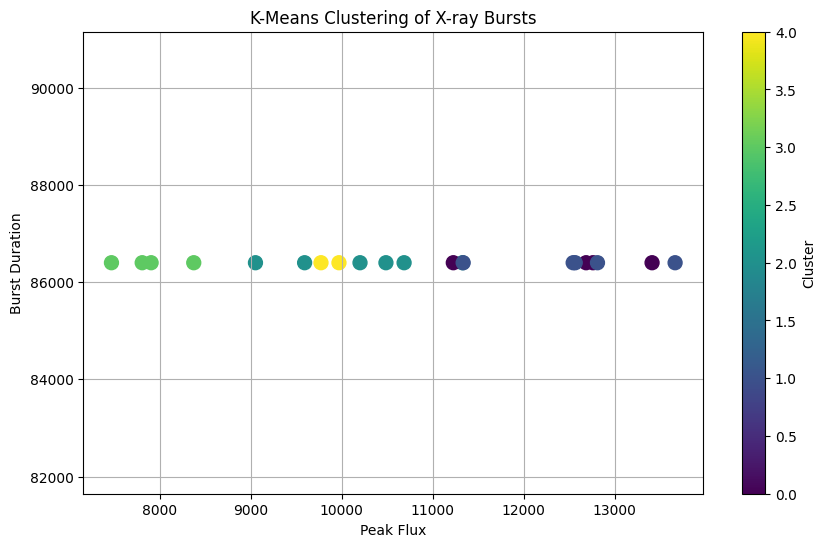

In [26]:
# Visualize the clusters
burst_detection.visualize_clusters(df_burst_classification)

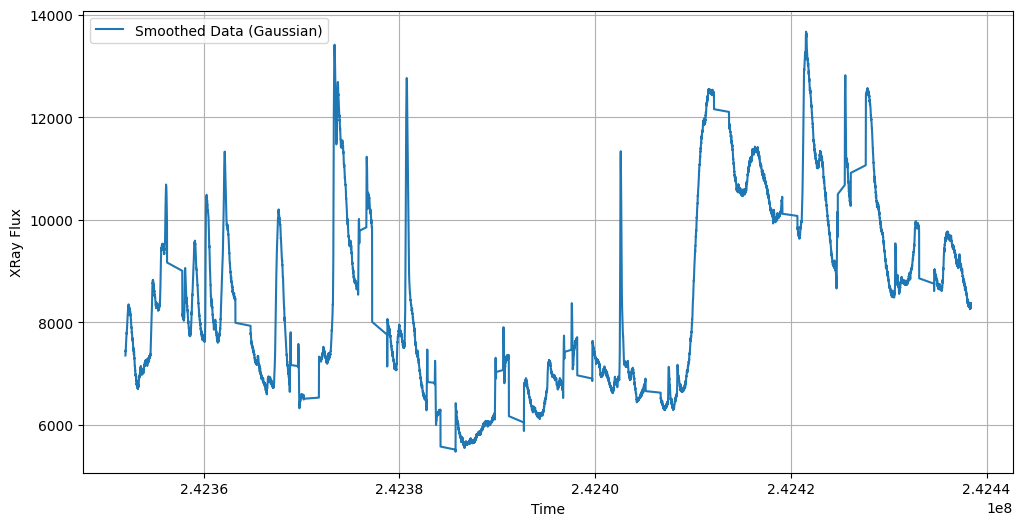

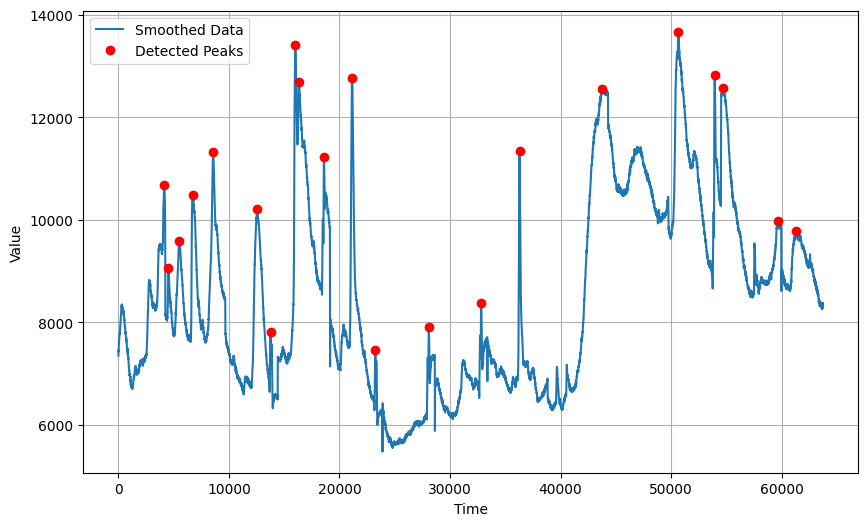

In [27]:
df_features = burst_detection.extract_features()
#for extracting all the useful features,so that to now apply the random forest model for further predictions

In [28]:
# Target Variables: we will predict 'rise_time', 'decay_time', and 'peak_flux'
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
X = df_features[['burst_duration', 'peak_flux', 'rise_time', 'decay_time']]
y_rise_time = df_features['rise_time']
y_decay_time = df_features['decay_time']
y_peak_flux = df_features['peak_flux']

# Split data into training and testing sets (e.g., for rise time prediction)
X_train, X_test, y_train_rise, y_test_rise = train_test_split(X, y_rise_time, test_size=0.2, random_state=42)
X_train, X_test, y_train_decay, y_test_decay = train_test_split(X, y_decay_time, test_size=0.2, random_state=42)
X_train, X_test, y_train_peak, y_test_peak = train_test_split(X, y_peak_flux, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
rf_rise_time = RandomForestRegressor(n_estimators=100, random_state=42)
rf_decay_time = RandomForestRegressor(n_estimators=100, random_state=42)
rf_peak_flux = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_rise_time.fit(X_train, y_train_rise)


RandomForestRegressor(random_state=42)

In [29]:

rf_decay_time.fit(X_train, y_train_decay)

RandomForestRegressor(random_state=42)

In [30]:
rf_peak_flux.fit(X_train, y_train_peak)

RandomForestRegressor(random_state=42)

In [31]:
# Predict on the test set
y_pred_rise = rf_rise_time.predict(X_test)
y_pred_decay = rf_decay_time.predict(X_test)
y_pred_peak = rf_peak_flux.predict(X_test)


In [32]:
# Evaluate the model's performance
from sklearn.metrics import r2_score, mean_squared_error
print("Rise Time Prediction")
print("R² Score:", r2_score(y_test_rise, y_pred_rise))
print("Mean Squared Error:", mean_squared_error(y_test_rise, y_pred_rise))

print("\nDecay Time Prediction")
print("R² Score:", r2_score(y_test_decay, y_pred_decay))
print("Mean Squared Error:", mean_squared_error(y_test_decay, y_pred_decay))

print("\nPeak Flux Prediction")
print("R² Score:", r2_score(y_test_peak, y_pred_peak))
print("Mean Squared Error:", mean_squared_error(y_test_peak, y_pred_peak))

Rise Time Prediction
R² Score: 0.9912354949249658
Mean Squared Error: 7080990.310440001

Decay Time Prediction
R² Score: 0.9912354949249658
Mean Squared Error: 7080990.310440002

Peak Flux Prediction
R² Score: 0.983517721988443
Mean Squared Error: 35807.21556513976


In [33]:
# Feature Importance
print("\nFeature Importance for Rise Time Prediction:")
print(rf_rise_time.feature_importances_)


Feature Importance for Rise Time Prediction:
[0.         0.01507455 0.46795338 0.51697207]


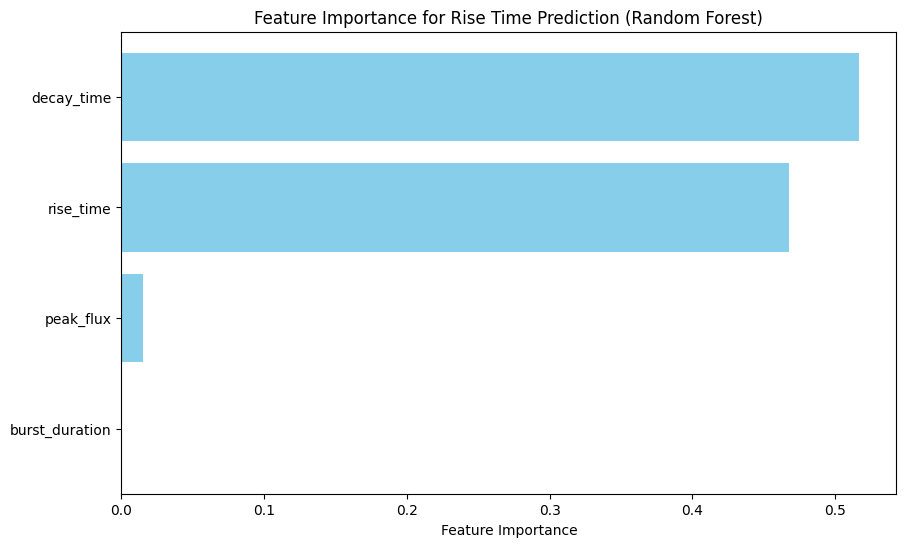

In [34]:
# Feature Importance
feature_importance = rf_rise_time.feature_importances_
feature_names = ['burst_duration', 'peak_flux', 'rise_time', 'decay_time']

# Visualize the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Rise Time Prediction (Random Forest)")
plt.show()

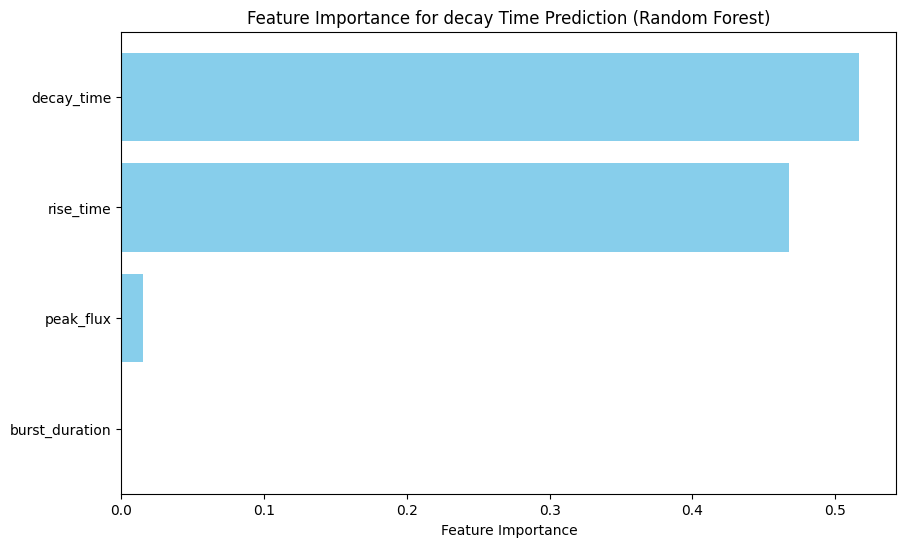

In [35]:
# Feature Importance
feature_importance = rf_decay_time.feature_importances_
feature_names = ['burst_duration', 'peak_flux', 'rise_time', 'decay_time']

# Visualize the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance for decay Time Prediction (Random Forest)")
plt.show()

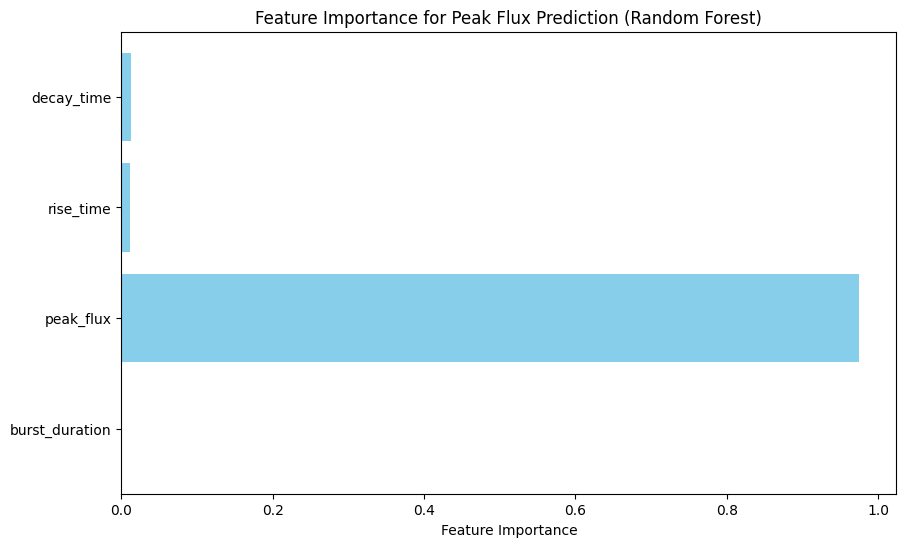

In [ ]:
# Feature Importance
feature_importance = rf_peak_flux.feature_importances_
feature_names = ['burst_duration', 'peak_flux', 'rise_time', 'decay_time']

# Visualize the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Peak Flux Prediction (Random Forest)")
plt.show()